# Finetuning foundation models using Terratorch (v.1.0.1)

The code for this tutorial was compiled and adapted from several examples available in 👉 [the official TerraTorch GitHub repository](https://github.com/IBM/terratorch/tree/main): 

- 💡 https://github.com/IBM/terratorch/tree/main/examples

In [1]:
import os
import sys
import torch
import gdown
import pathlib
import terratorch
import albumentations
import lightning.pytorch as pl
import matplotlib.pyplot as plt
from terratorch.datamodules import GenericNonGeoSegmentationDataModule
import warnings
warnings.filterwarnings('ignore')

from dataclasses import dataclass
import tarfile
import zipfile
import time
import functools

from tqdm import notebook as tqdm
import xarray as xr

import random
import rich

from collections.abc import Callable

%matplotlib inline

In [2]:
USER = os.environ.get("USER")
PROJECT = os.environ.get("PROJECT_training2504")
SCRATCH = os.environ.get("SCRATCH_training2504")
print(f"Current user: {USER}")
print(f"Project location: {PROJECT}")
print(f"Scratch location: {SCRATCH}")

Current user: maurogiovanni1
Project location: /p/project1/training2504
Scratch location: /p/scratch/training2504


## Data preparation

This section shows how to download the downstream dataset(s) for different finetuning tasks:

- 🗺️ **HLS Burn Scars**: Harmonized Landsat and Sentinel-2 imagery of burn scars and the associated masks for the years 2018-2021 over the United States. The dataset comprises 804 512x512 scenes. More information at 👉 [the NASA-IBM Hugging Face community](https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars)

In [3]:
data_root = pathlib.Path(f"{SCRATCH}/data")

In [4]:
@dataclass
class DatasetInfo:
    name: str
    archive_path: pathlib.Path
    files_path: pathlib.Path

In [5]:
datasets_registry = {
    "hls_burn_scars": DatasetInfo("HLS Burn Scars", data_root / "hls_burn_scars.tar.gz", data_root / "hls_burn_scars"),
    "multi_temporal_crops": DatasetInfo("Multi Temporal Crops", data_root / "multi-temporal-crop-classification-subset.tar.gz", data_root / "multi-temporal-crop-classification-subset"),
    "above_ground_biomass": DatasetInfo("Granite Biomass", data_root / "granite-geospatial-biomass-dataset.zip", data_root / "granite-geospatial-biomass-dataset"),  
}
rich.print(datasets_registry)

{
    'hls_burn_scars': DatasetInfo(
        name='HLS Burn Scars',
        archive_path=PosixPath('/p/scratch/training2504/data/hls_burn_scars.tar.gz'),
        files_path=PosixPath('/p/scratch/training2504/data/hls_burn_scars')
    ),
    'multi_temporal_crops': DatasetInfo(
        name='Multi Temporal Crops',
        archive_path=PosixPath('/p/scratch/training2504/data/multi-temporal-crop-classification-subset.tar.gz'),
        files_path=PosixPath('/p/scratch/training2504/data/multi-temporal-crop-classification-subset')
    ),
    'above_ground_biomass': DatasetInfo(
        name='Granite Biomass',
        archive_path=PosixPath('/p/scratch/training2504/data/granite-geospatial-biomass-dataset.zip'),
        files_path=PosixPath('/p/scratch/training2504/data/granite-geospatial-biomass-dataset')
    )
}

In [6]:
def extract_dataset(info: DatasetInfo, extractor: Callable[[pathlib.Path], None]):
    if info.files_path.exists():
        print(f" Dataset '{info.name}' already exists at {info.files_path}.")
    else:
        print(f"Extracting archive at: {info.files_path}")
        start = time.time()
        extractor(info.archive_path)
        end = time.time()
        print(f"Extraction of dataset '{info.name}' took {end - start:.1f}s.")  

In [7]:
def extract_tar(src, dest):
    with tarfile.open(src, mode="r") as archive:
        archive.extractall(path=dest, filter="data")
        
def extract_zip(src, dest):
    with zipfile.ZipFile(src, mode='r') as archive:
        archive.extractall(path=dest)

In [8]:
extract_dataset(datasets_registry["hls_burn_scars"], extractor=functools.partial(extract_tar, dest=data_root))
extract_dataset(datasets_registry["multi_temporal_crops"], extractor=functools.partial(extract_tar, dest=data_root))

 Dataset 'HLS Burn Scars' already exists at /p/scratch/training2504/data/hls_burn_scars.
 Dataset 'Multi Temporal Crops' already exists at /p/scratch/training2504/data/multi-temporal-crop-classification-subset.


## Burn Scars classification

- **Type of problem**: binary classification
- **Fine-tuning dataset**: [https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars](https://huggingface.co/datasets/ibm-nasa-geospatial/hls_burn_scars)

In [9]:
dataset_info = datasets_registry["hls_burn_scars"]
rich.print(dataset_info)

DatasetInfo(
    name='HLS Burn Scars',
    archive_path=PosixPath('/p/scratch/training2504/data/hls_burn_scars.tar.gz'),
    files_path=PosixPath('/p/scratch/training2504/data/hls_burn_scars')
)

In [10]:
def get_sample_paths(sample_id: str, info: DatasetInfo) -> dict[str, pathlib.Path]:
    template = "subsetted_512x512_HLS.S30.{}.4{}.tif"
    suffixes, keys = (".mask", "_merged"), ("mask", "pixel_values")
    paths = map(lambda suffix: info.files_path / "data" / template.format(sample_id, suffix), suffixes)
    
    return dict(zip(keys, paths))

get_hls_sample_paths = functools.partial(get_sample_paths, info=datasets_registry["hls_burn_scars"])

In [11]:
sample_paths = get_hls_sample_paths("T10SEH.2018190.v1")
for path in sample_paths.values():
    assert path.exists()
print("👍")

👍


In [12]:
def load_sample(sample_paths):
    return {key: xr.open_dataset(sample_paths[key], engine="rasterio") for key in sample_paths}

def extract_rgb_and_mask(sample):
    mask = sample["mask"]
    rgb = sample["pixel_values"].sel(band=[3, 2, 1]).transpose("y", "x", "band")
    mask_values, rgb_values = map(lambda dataset: dataset.band_data.to_numpy(), (mask, rgb))

    return rgb_values, mask_values[0]

In [13]:
def visualize_sample(sample, brightness=5, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=2, **kwargs)
    fig.suptitle("T10SEH.2018190.v1")
    fig.subplots_adjust(top=1.45)
    rgb, mask = extract_rgb_and_mask(sample)
    axes[0].imshow(brightness * rgb)
    axes[1].imshow(mask, cmap="seismic")

    plt.show()

In [14]:
sample = load_sample(sample_paths)
rich.print(sample)

{
    'mask': <xarray.Dataset> Size: 1MB
Dimensions:      (band: 1, x: 512, y: 512)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 5.649e+05 5.649e+05 ... 5.802e+05 5.802e+05
  * y            (y) float64 4kB 4.287e+06 4.287e+06 ... 4.272e+06 4.272e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 1MB ...,
    'pixel_values': <xarray.Dataset> Size: 6MB
Dimensions:      (band: 6, x: 512, y: 512)
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 4kB 5.649e+05 5.649e+05 ... 5.802e+05 5.802e+05
  * y            (y) float64 4kB 4.287e+06 4.287e+06 ... 4.272e+06 4.272e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 6MB ...
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0355..1.7885].


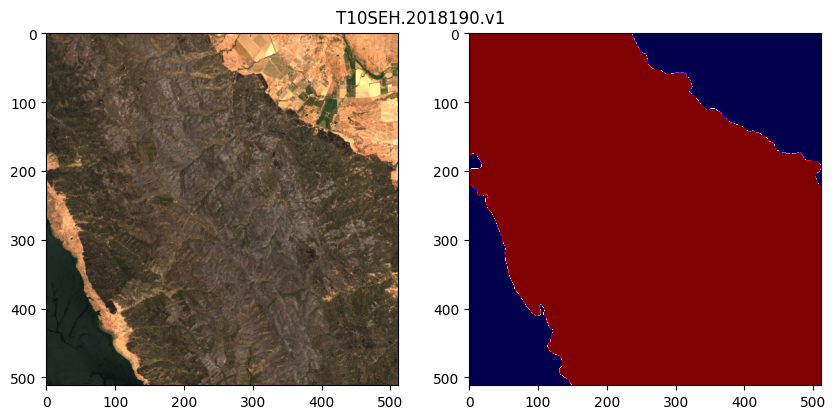

In [15]:
visualize_sample(sample, figsize=(10, 10))

In [16]:
with open(dataset_info.files_path / "splits" / "train.txt", mode="r") as file:
    train_tags = file.read().strip().split("\n")
print(f"Training samples: {len(train_tags)}")

Training samples: 524


In [17]:
random.seed(1337)
num_picks = 4
picks = random.choices(train_tags, k=num_picks)
rich.print(picks)

['T13TEL.2020307.v1', 'T13SDT.2019184.v1', 'T12RYV.2018152.v1', 'T13TCG.2020247.v1']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.063..2.2515001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.087..1.5695].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.099..1.8729999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0295..2.3630002].


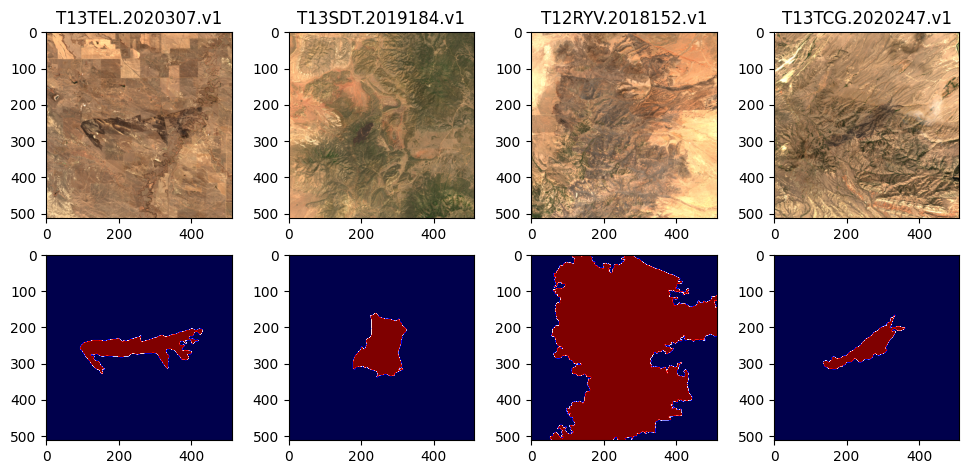

In [18]:
brightness = 5
fig, axes = plt.subplots(nrows=2, ncols=num_picks, figsize=(12, 12))
for idx, tag in enumerate(picks):
    sample = load_sample(get_hls_sample_paths(tag))
    rgb, mask = extract_rgb_and_mask(sample)
    axes[0][idx].set_title(tag)
    axes[0][idx].imshow(brightness * rgb) 
    axes[1][idx].imshow(mask, cmap="seismic") 
fig.subplots_adjust(top=.45)
plt.show()

### Data Module

In [19]:
hls_data_root = dataset_info.files_path / "data"
hls_splits_root = dataset_info.files_path / "splits"
assert hls_data_root.exists() and hls_splits_root.exists()
print("👍")

👍


In [20]:
hls_burnscars_means=[
  0.0333497067415863,
  0.0570118552053618,
  0.0588974813200132,
  0.2323245113436119,
  0.1972854853760658,
  0.1194491422518656,
]

hls_burnscars_stds=[
  0.0226913556882377,
  0.0268075602230702,
  0.0400410984436278,
  0.0779173242367269,
  0.0870873883814014,
  0.0724197947743781,
]

In [21]:
datamodule = terratorch.datamodules.GenericNonGeoSegmentationDataModule(
    # Datamodule params
    batch_size=4,
    num_workers=2,
    num_classes=2,
    
    # Dataset paths 
    train_data_root = hls_data_root,
    train_label_data_root = hls_data_root,
    val_data_root = hls_data_root,
    val_label_data_root = hls_data_root,
    test_data_root = hls_data_root,
    test_label_data_root = hls_data_root,
    
    # Dataset splits
    train_split = hls_splits_root / "train.txt",
    val_split=hls_splits_root / "val.txt",
    test_split= hls_splits_root / "test.txt",
    
    # Dataset suffixes
    img_grep= "*_merged.tif",
    label_grep="*.mask.tif",
    
    # Transforms
    train_transform=[
        albumentations.D4(), # random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
    ],
    val_transform=None,  # using ToTensor() by default
    test_transform=None,
        
    # Statistics
    means=hls_burnscars_means,
    stds=hls_burnscars_stds,

    # Sampling options
    no_data_replace=0,
    no_label_replace=-1,
    # We use all six bands of the data, so we don't need to define dataset_bands and output_bands.
)

# Setup train and val datasets
datamodule.setup("fit")

In [22]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
val_dataset = datamodule.val_dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 524
Number of validation samples: 160


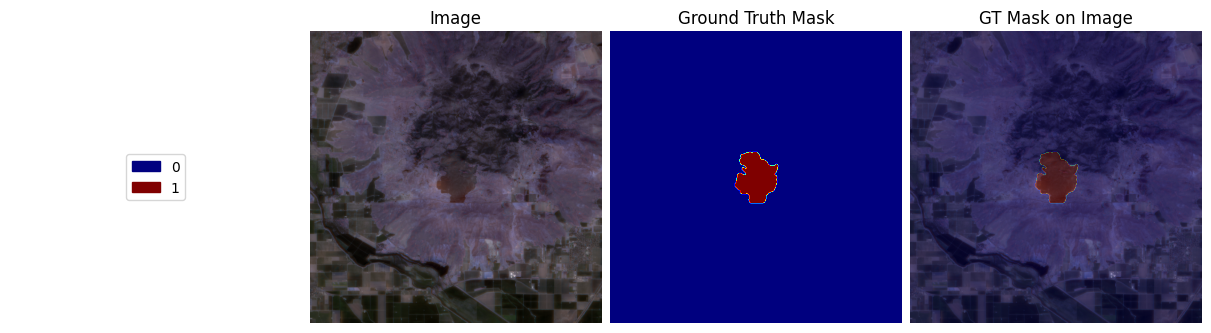

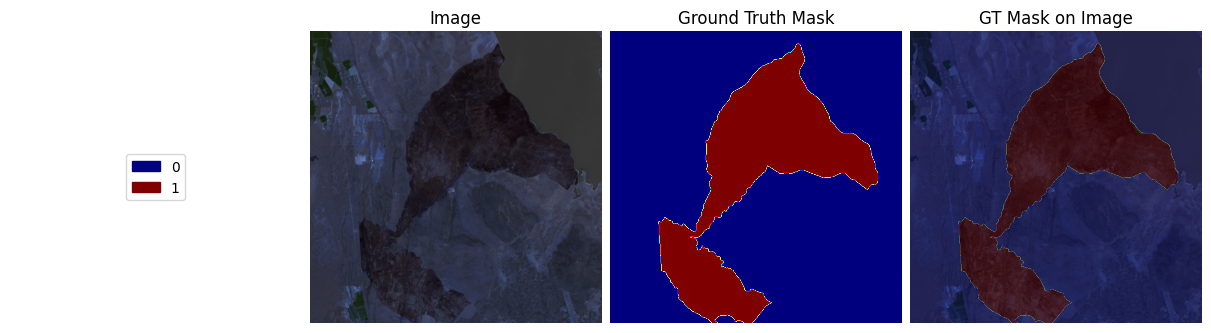

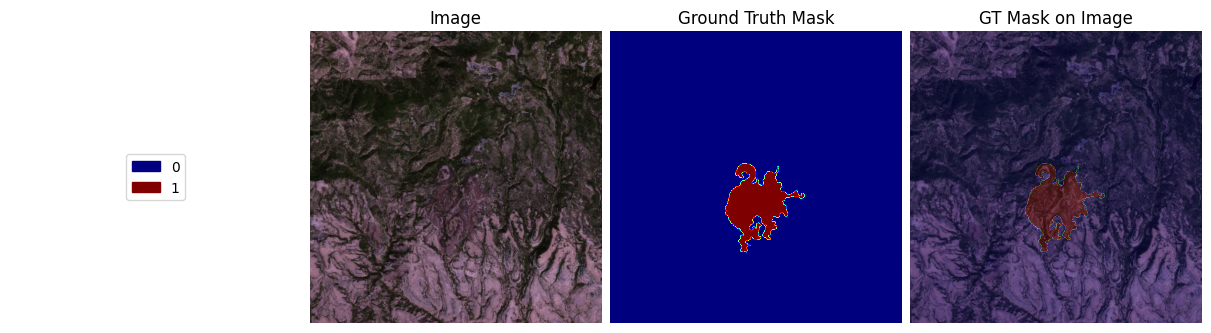

In [23]:
# plotting a few samples
for idx in (0, 6, 10):
     val_dataset.plot(val_dataset[idx])
plt.show()

In [24]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
print(f"Number of test samples: {len(test_dataset)}")

Number of test samples: 120


In [25]:
def run_test_and_visual_inspection(model,ckpt_path):

    # let's run the model on the test set
    trainer.test(model, datamodule=datamodule, ckpt_path=ckpt_path)

    # now we can use the model for predictions and plotting!
    model = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
        ckpt_path,
        model_factory=model.hparams.model_factory,
        model_args=model.hparams.model_args,
    )
    
    test_loader = datamodule.test_dataloader()
    
    with torch.no_grad():
        batch = next(iter(test_loader))
        images = datamodule.aug(batch)
        images = batch["image"].to(model.device)
        masks = batch["mask"].numpy()
    
        outputs = model(images)
        preds = torch.argmax(outputs.output, dim=1).cpu().numpy()
    
    for i in range(4):
        sample = {key: batch[key][i] for key in batch}
        sample["prediction"] = preds[i]
        sample["image"] = sample["image"].cpu()
        sample["mask"] = sample["mask"].cpu()
        test_dataset.plot(sample)

### Segmentation Task with a ResNet-50 Encoder

In [26]:
model_args = {
    "backbone":"resnet50", # see smp_encoders.keys()
    'model': 'Unet', # 'DeepLabV3', 'DeepLabV3Plus', 'FPN', 'Linknet', 'MAnet', 'PAN', 'PSPNet', 'Unet', 'UnetPlusPlus' 
    "bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
    "in_channels": 6,
    "num_classes": 2,
    "pretrained": True,
}
rich.print(model_args)

{
    'backbone': 'resnet50',
    'model': 'Unet',
    'bands': ['BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2'],
    'in_channels': 6,
    'num_classes': 2,
    'pretrained': True
}

In [27]:
task = terratorch.tasks.SemanticSegmentationTask(
    model_args=model_args,
    model_factory="SMPModelFactory",
    loss="ce",
    lr=1e-4,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=True,
    class_names=['Not burned', 'Burned'],
    class_weights=[0.1, 0.9]
)

### Trainer

In [28]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"{SCRATCH}/{USER}/output/burnscars/checkpoints/",
    mode="max",
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="resnet50-best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=1, # For demos
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir=f"{SCRATCH}/{USER}/output/burnscars",
    detect_anomaly=False,
)

Seed set to 0
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(task, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ SMPModelWrapper  │ 32.5 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 9.0 M                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 32.5 M                                                                                               
Total estimated model params size (MB): 130                                                                        
Modules in train mode: 254                                                                                         
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


In [30]:
ckpt_path = pathlib.Path(f"{SCRATCH}/{USER}/output/burnscars/checkpoints/resnet50-best-epoch=00.ckpt")
assert ckpt_path.exists()
print("👍")

👍


Restoring states from the checkpoint path at /p/scratch/training2504/maurogiovanni1/output/burnscars/checkpoints/resnet50-best-epoch=00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /p/scratch/training2504/maurogiovanni1/output/burnscars/checkpoints/resnet50-best-epoch=00.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric               ┃              DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/Multiclass_Accuracy        │           0.9104354381561279           │
│        test/Multiclass_F1_Score        │           0.9104354977607727           │
│     test/Multiclass_Jaccard_Index      │           0.7053647041320801           │
│  test/Multiclass_Jaccard_Index_Micro   │           0.8355957269668579           │
│               test/loss                │           0.3376738131046295           │
│     test/multiclassaccuracy_Burned     │           0.892090380191803            │
│   test/multiclassaccuracy_Not burned   │           0.9125711917877197           │
│   test/multiclassjaccardindex_Burned   │           0.5094802975654602           │
│ test/multiclassjaccardindex_Not burned │           0.9012490510940552           │
└────────────────────────────────────────┴────────────────────────────────────────┘

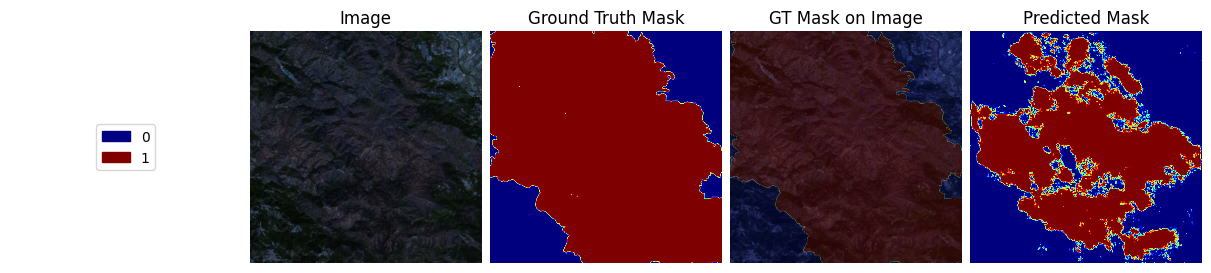

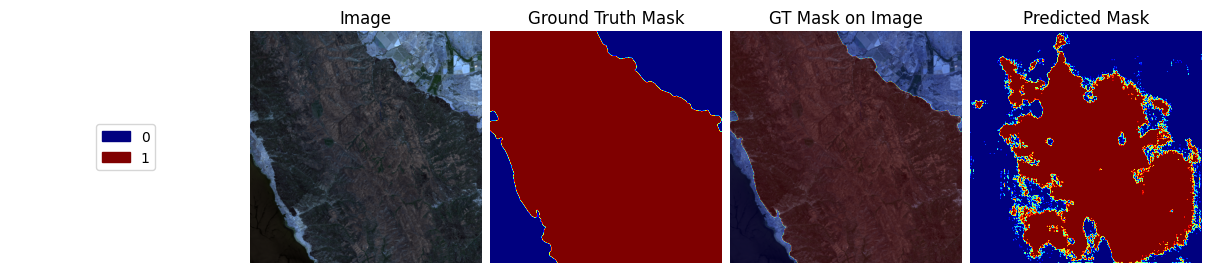

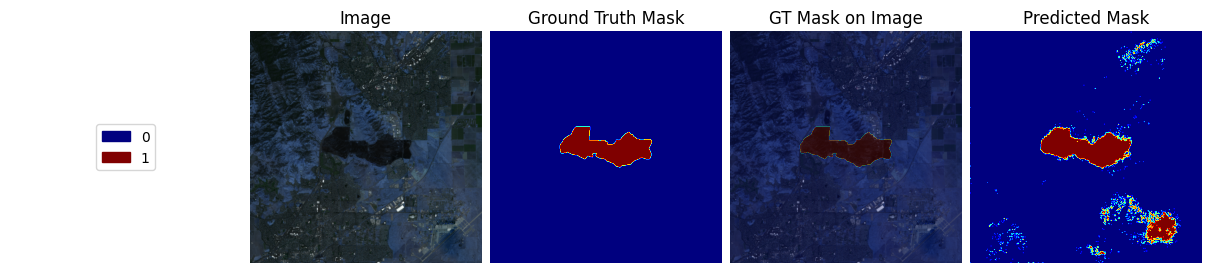

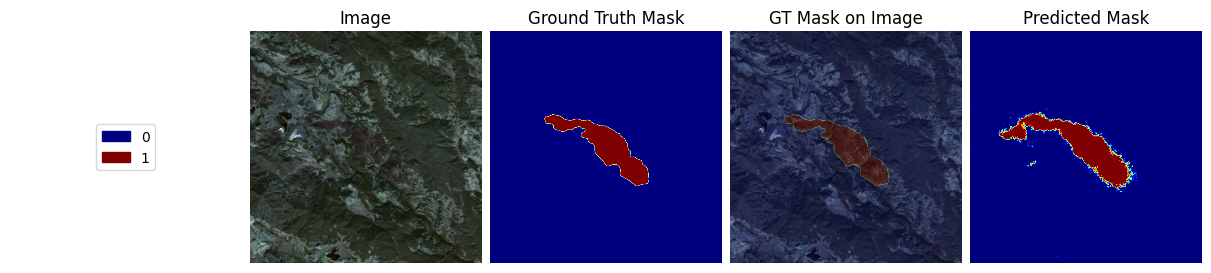

In [31]:
run_test_and_visual_inspection(task, ckpt_path)
plt.show()

### Task with a Prithvi-v2 Encoder

In [32]:
model_args={
    # Backbone (encoder)
    "backbone": "prithvi_eo_v2_300", # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
    "backbone_pretrained": True,
    "backbone_num_frames": 1, # 1 is the default value,
    "backbone_img_size": 512,
    "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
    # "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata
    
    # Necks 
    "necks": [
        {
            "name": "SelectIndices",
            # "indices": [2, 5, 8, 11] # indices for prithvi_eo_v1_100
            "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
            # "indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
        },
        {"name": "ReshapeTokensToImage",},
        {"name": "LearnedInterpolateToPyramidal"}            
    ],
    
    # Decoder
    "decoder": "UNetDecoder",
    "decoder_channels": [512, 256, 128, 64],
    
    # Head
    "head_dropout": 0.1,
    "num_classes": 2,
}
rich.print(model_args)

{
    'backbone': 'prithvi_eo_v2_300',
    'backbone_pretrained': True,
    'backbone_num_frames': 1,
    'backbone_img_size': 512,
    'backbone_bands': ['BLUE', 'GREEN', 'RED', 'NIR_NARROW', 'SWIR_1', 'SWIR_2'],
    'necks': [
        {'name': 'SelectIndices', 'indices': [5, 11, 17, 23]},
        {'name': 'ReshapeTokensToImage'},
        {'name': 'LearnedInterpolateToPyramidal'}
    ],
    'decoder': 'UNetDecoder',
    'decoder_channels': [512, 256, 128, 64],
    'head_dropout': 0.1,
    'num_classes': 2
}

In [33]:
# Model
task = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args=model_args,
    loss="ce",
    optimizer="AdamW",
    lr=1e-4,
    ignore_index=-1,
    freeze_backbone=True, # Only to speed up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
    class_names=['Not burned', 'Burned']  # optionally define class names
)

### Trainer

In [34]:
pl.seed_everything(1337)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=f"{SCRATCH}/{USER}/output/burnscars/checkpoints/",
    mode="max",
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="best-{epoch:02d}",
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Deactivate multi-gpu because it often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True,  # Uses TensorBoard by default
    max_epochs=1, # For demos
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir=f"{SCRATCH}/{USER}/output/burnscars",
    detect_anomaly=False,
)

Seed set to 1337
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(task, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ PixelWiseModel   │  324 M │ train │
│ 1 │ criterion     │ CrossEntropyLoss │      0 │ train │
│ 2 │ train_metrics │ MetricCollection │      0 │ train │
│ 3 │ val_metrics   │ MetricCollection │      0 │ train │
│ 4 │ test_metrics  │ ModuleList       │      0 │ train │
└───┴───────────────┴──────────────────┴────────┴───────┘

Trainable params: 20.3 M                                                                                           
Non-trainable params: 303 M                                                                                        
Total params: 324 M                                                                                                
Total estimated model params size (MB): 1.3 K                                                                      
Modules in train mode: 617                                                                                         
Modules in eval mode: 0

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


In [36]:
ckpt_path = pathlib.Path(f"{SCRATCH}/{USER}/output/burnscars/checkpoints/best-epoch=00.ckpt")
assert ckpt_path.exists()
print("👍")

👍


Restoring states from the checkpoint path at /p/scratch/training2504/maurogiovanni1/output/burnscars/checkpoints/best-epoch=00.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /p/scratch/training2504/maurogiovanni1/output/burnscars/checkpoints/best-epoch=00.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric               ┃              DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/Multiclass_Accuracy        │           0.9349859356880188           │
│        test/Multiclass_F1_Score        │           0.9349859356880188           │
│     test/Multiclass_Jaccard_Index      │           0.7471028566360474           │
│  test/Multiclass_Jaccard_Index_Micro   │           0.8779095411300659           │
│               test/loss                │          0.22023829817771912           │
│     test/multiclassaccuracy_Burned     │           0.8105133771896362           │
│   test/multiclassaccuracy_Not burned   │           0.9494770169258118           │
│   test/multiclassjaccardindex_Burned   │           0.5652219653129578           │
│ test/multiclassjaccardindex_Not burned │           0.9289836883544922           │
└────────────────────────────────────────┴────────────────────────────────────────┘

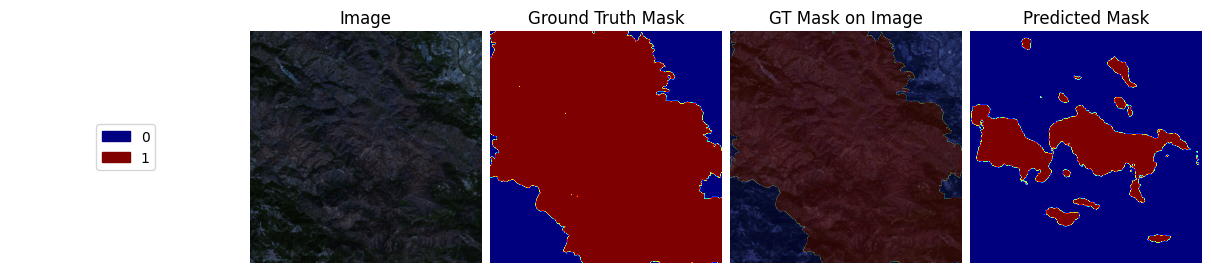

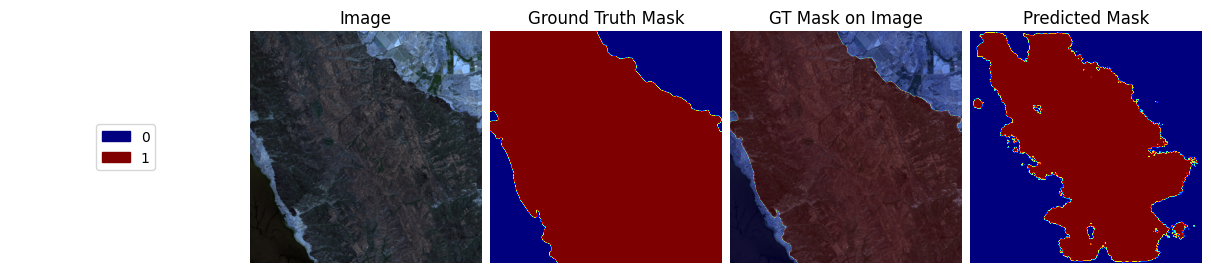

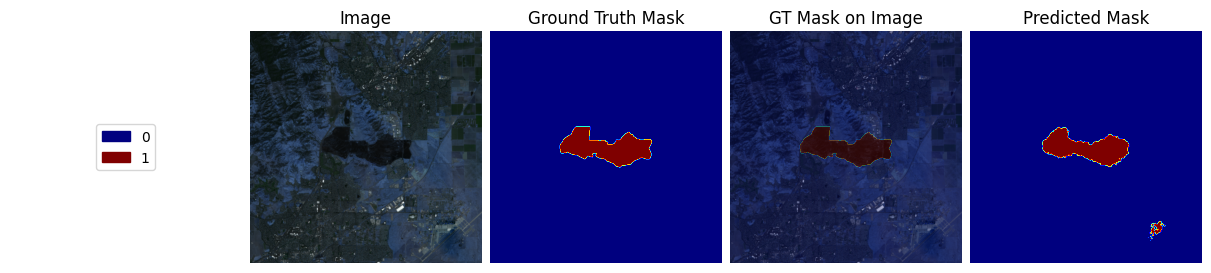

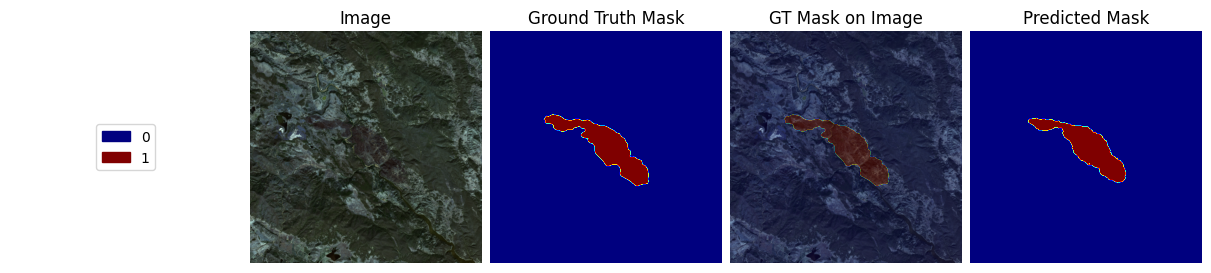

In [37]:
run_test_and_visual_inspection(task, ckpt_path)
plt.show()

In [40]:
ckpt_path = pathlib.Path(f"{SCRATCH}/{USER}/output/burnscars/checkpoints/best-epoch=69.ckpt")
assert ckpt_path.exists(), ckpt_path
print("👍")

👍


Restoring states from the checkpoint path at /p/scratch/training2504/maurogiovanni1/output/burnscars/checkpoints/best-epoch=69.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /p/scratch/training2504/maurogiovanni1/output/burnscars/checkpoints/best-epoch=69.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric               ┃              DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/Multiclass_Accuracy        │           0.9807682633399963           │
│        test/Multiclass_F1_Score        │           0.9807683825492859           │
│     test/Multiclass_Jaccard_Index      │           0.9024698734283447           │
│  test/Multiclass_Jaccard_Index_Micro   │           0.9622624516487122           │
│               test/loss                │          0.06332477927207947           │
│     test/multiclassaccuracy_Burned     │           0.8761271834373474           │
│   test/multiclassaccuracy_Not burned   │           0.9929506182670593           │
│   test/multiclassjaccardindex_Burned   │           0.8261050581932068           │
│ test/multiclassjaccardindex_Not burned │           0.9788346886634827           │
└────────────────────────────────────────┴────────────────────────────────────────┘

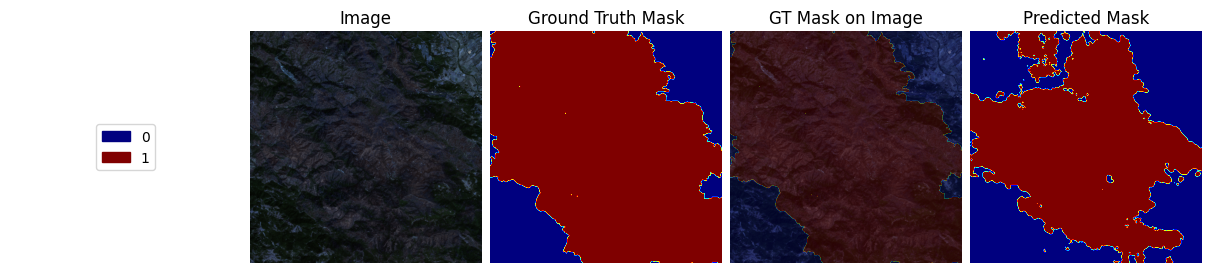

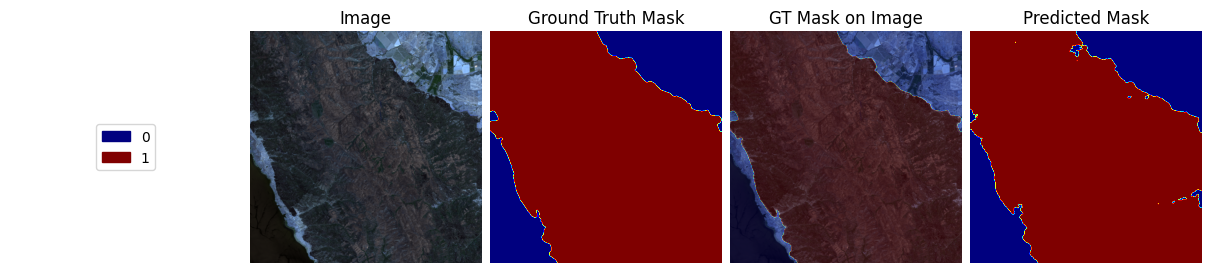

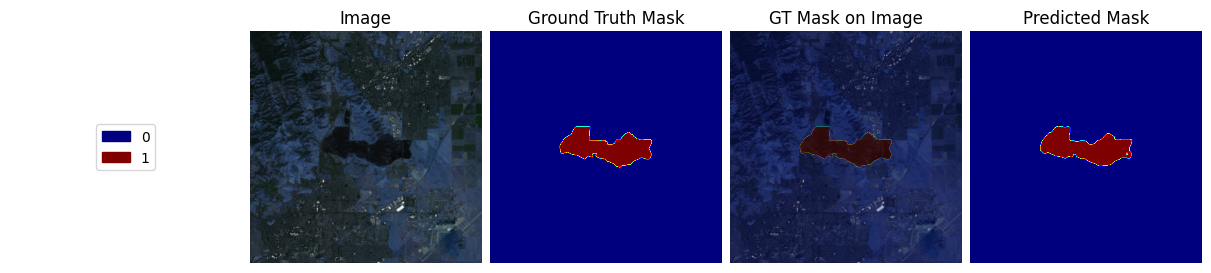

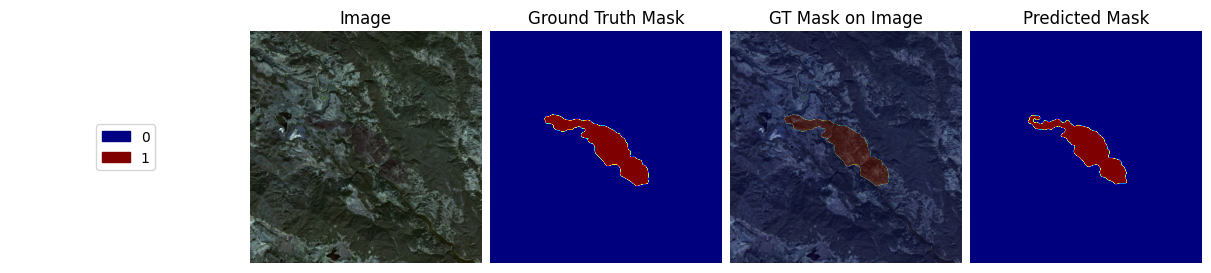

In [41]:
run_test_and_visual_inspection(task, ckpt_path)
plt.show()